# T90 - HRD

In this notebook, we analyze the datasets only in T90-Spectral Hardness feature space. The model created in step 4 (see notebooks/04_model.ipynb) are examined using different metrics and the cross-catalogue comparisons among altermative datasets are performed.

**Problems**

1G model is the model which has only 1 Gaussian. In other words, it assumes that the data is coming from 1 Gaussian. This means that the data is not clustered. Some statistical tests included in this study cannot yield results on models that include 1 cluster (unclustered data), because of the mathematical formulation of the tests. Under these circumstances, model 1 cluster, cannot be fairly compared to the alternative models. Another metric should be used to assess the possibility of 1G model.

**Solution**

1G model is equivalent to an unclustered data. Hence, if clustering tendency of the data yields a result which indicates that data is clusterable, it means that the 1G model is not the optimal model -it cdoes not need to be compared to the alternative model-. Otherwise, 1G model should be considered as an alternative model. Hopkins Statistical test is used to assess clustering tendency. See the paper for the details amd the interpretation of the method.

**Results**



....

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing libraries:

In [147]:
import sys
import numpy as np
import pandas as pd
from typing import List, Union, Optional

# add grbttools to path
sys.path.append("../")

from grbtools import env, data as dt, disp, models as md, analysis as an, stats as st
from grbtools.gmm import GaussianMixtureModel


logger = env.get_logger()

Notebook settings

In [18]:
FEATS = ["lgT90", "lgHrd"]
BATSE = "batse"
FERMI = "fermi"
SWIFT = "swift"

Necessary methods:

In [162]:
def plot_models(model_list: List[GaussianMixtureModel], df: pd.DataFrame):
    # get catalog name and features
    catalog_name = df.index.name
    features = df.columns
    # features as txt
    features_txt = "-".join(features)

    # plot models
    disp.plot_models_as_grid(
        model_list,
        df,
        cols=features,
        n_cols=3,
        figsize=(12, 10),
        title=f"{catalog_name} | {features_txt}",
        show_decision_boundary=True,
        show_confidence_ellipses=True,
        show_confidence_ellipsoids=True,
        show_cluster_centers=True,
        save_kwargs={
            "filename": f"models__{catalog_name}_{features_txt}",
            "subdir": f"models/{catalog_name}/{features_txt}",
        },
    )


def evaluate_models(
    model_list: List[GaussianMixtureModel], df: pd.DataFrame, save: bool = True
):
    # metrics = ["wcss_mah", "dbs_mah", "chs_mah"]
    metrics = None
    for cnt, model in enumerate(model_list, 1):
        logger.info(f"[{cnt}/{len(model_list)}] Evaluating model: {model.model_name}")
        md.evaluate_model(model, df, metrics=metrics, save_scores=True)


def plot_scores(catalog_name: str, features: List[str], clusterable: bool = False):
    # features as txt
    features_txt = "-".join(features)

    # figure file name
    figure_file = f"scores__{catalog_name}_{features_txt}"
    # title of the figure
    title_txt = f"{catalog_name.upper()} | {'-'.join(features)}"

    # get scores
    scores = md.get_model_scores(catalog_name=catalog_name, features=features)
    if clusterable:
        scores = scores.drop(scores[scores['n_components'] == 1].index)

    xvalues = [f"{t}G" for t in scores["n_components"].values]
    disp.plot_scores_as_grid(
        scores,
        xvalues,
        align_scores="higher",
        normalize_scores=False,
        highlight_best=True,
        n_ax_columns=4,
        hspace=0.4,
        title=title_txt,
        save_kwargs={
            "filename": figure_file,
            "subdir": f"models/{catalog_name}/{features_txt}",
            "fmt": "pdf",
        },
    )

def load_models(catalog_name, features):
    return md.load_all_models(catalog_name, features)

def plot_heatmap(catalogue_name, features, title=None, clusterable=False):
    scores = md.get_model_scores(catalog_name=catalogue_name, features=features)
    scores = scores.drop(columns=["wcss_euc", "wcss_mah"])
    if clusterable:
        scores = scores.drop(scores[scores['n_components'] == 1].index)
    disp.plot_scores_as_heatmap(df_scores=scores, title=title)


## 1. CGRO/BATSE

Load dataset and models.

[I]: >>> Dataset BATSE loaded with features: ['lgT90', 'lgHrd']
[I]:   > Number of GRBs: 1924


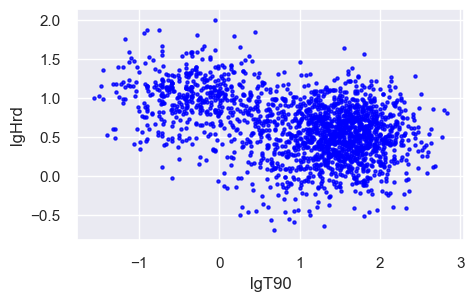

In [167]:
df_batse_t90_hrd = dt.load_dataset(BATSE, FEATS, plot_data=True)
batse_models = load_models(BATSE, FEATS)

Apply Hopkins statistic test. (if >0.75, then clusterable)

In [164]:
hopkins_batse = st.hopkins_statistic(df_batse_t90_hrd.values)
print("Data is clusterable." if hopkins_batse>0.75 else "Data is not clusterable.")
clusterability_batse = True if hopkins_batse>0.75 else False

Data is clusterable.


Display all models.

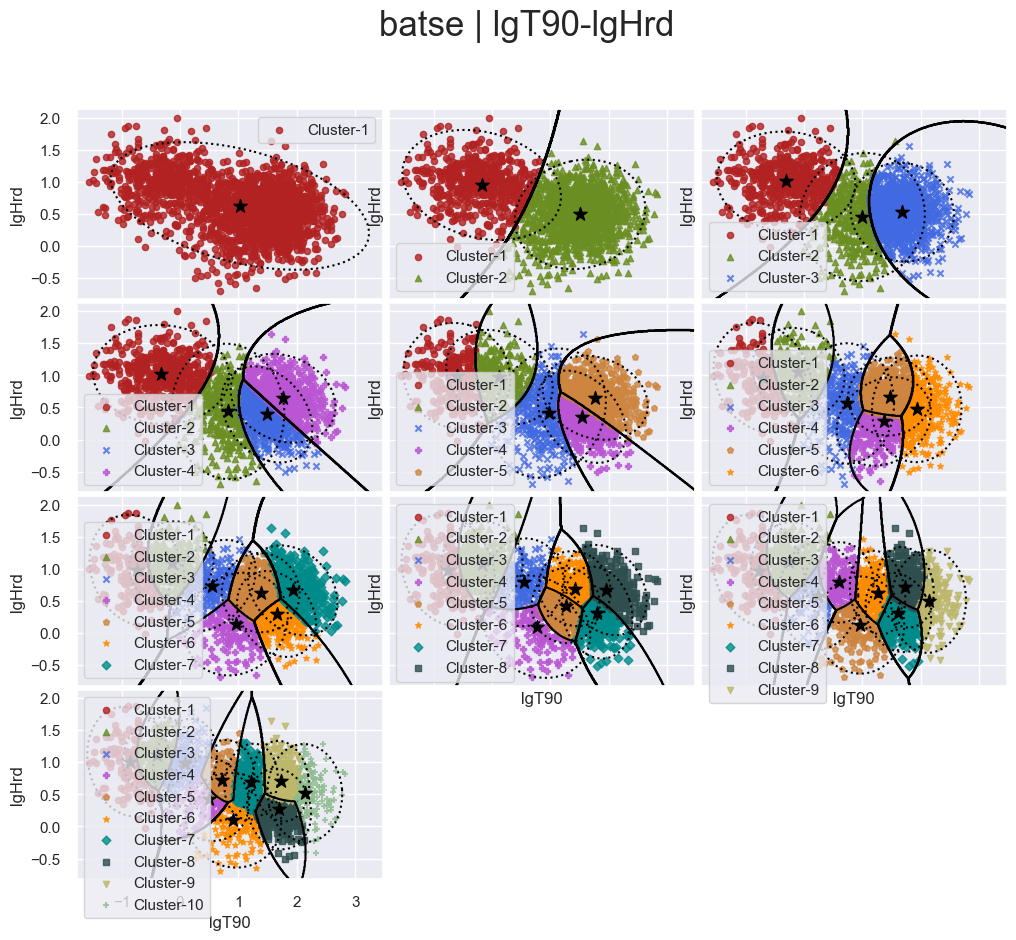

In [155]:
plot_models(batse_models, df_batse_t90_hrd)

Evaluate all models.

In [24]:
evaluate_models(batse_models, df_batse_t90_hrd, save=True)

[I]: [1/10] Evaluating model: batse_lgT90-lgHrd_1G
[I]: [2/10] Evaluating model: batse_lgT90-lgHrd_2G
[I]: [3/10] Evaluating model: batse_lgT90-lgHrd_3G
[I]: [4/10] Evaluating model: batse_lgT90-lgHrd_4G
[I]: [5/10] Evaluating model: batse_lgT90-lgHrd_5G
[I]: [6/10] Evaluating model: batse_lgT90-lgHrd_6G
[I]: [7/10] Evaluating model: batse_lgT90-lgHrd_7G
[I]: [8/10] Evaluating model: batse_lgT90-lgHrd_8G
[I]: [9/10] Evaluating model: batse_lgT90-lgHrd_9G
[I]: [10/10] Evaluating model: batse_lgT90-lgHrd_10G


Display model scores.

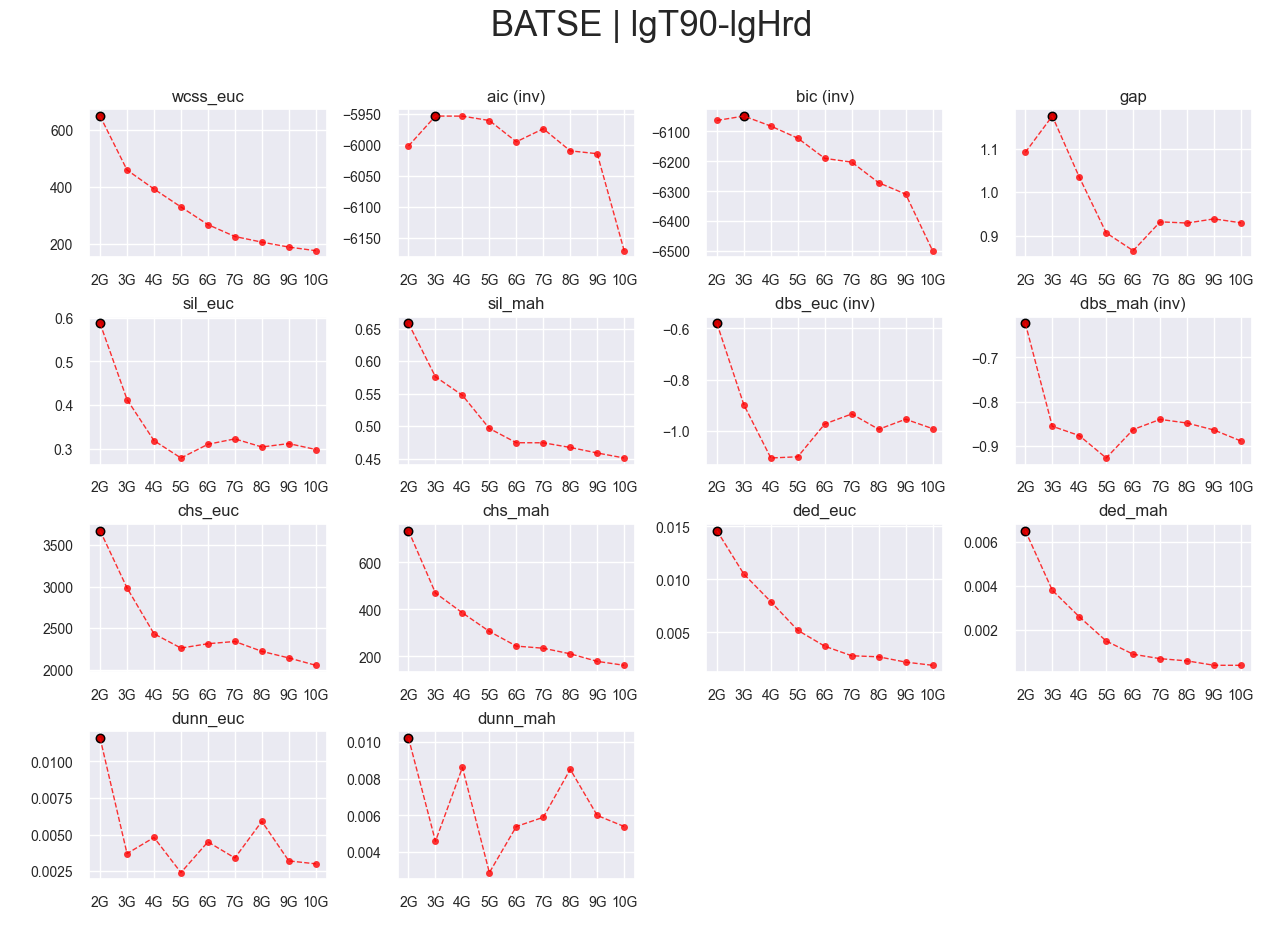

In [159]:
plot_scores(BATSE, FEATS, clusterable=clusterability_batse)

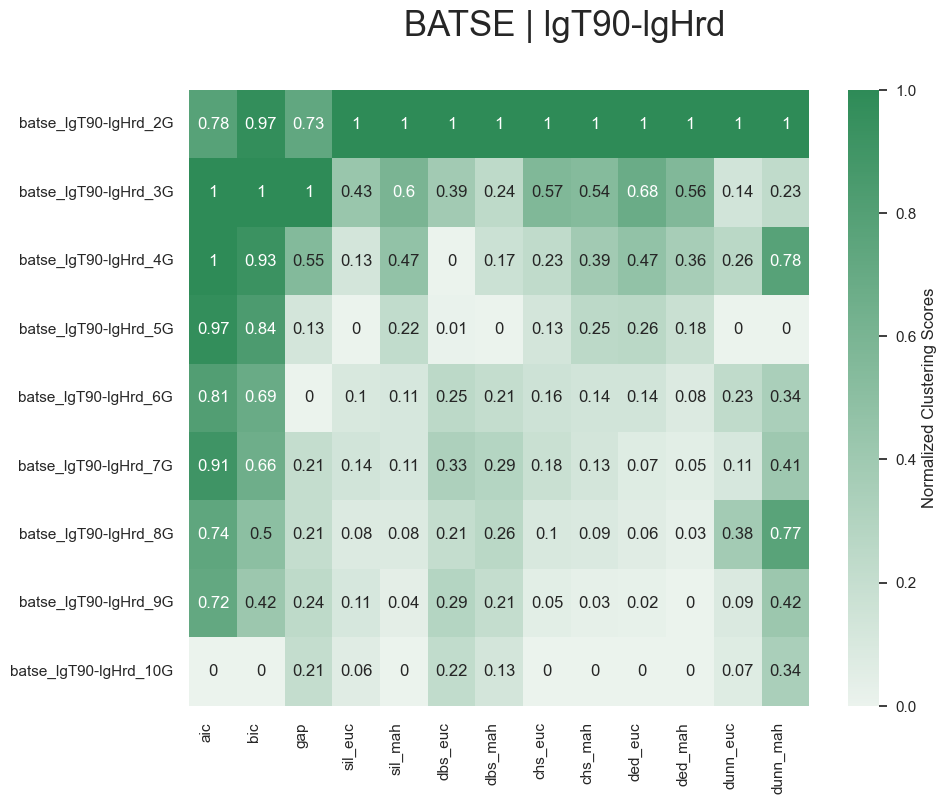

In [166]:
plot_heatmap(BATSE, FEATS, title=BATSE.upper() + " | " + "-".join(FEATS), clusterable=clusterability_batse)

## 2. FERMI/GBM

Load dataset and models.

[I]: >>> Dataset FERMI loaded with features: ['lgT90', 'lgHrd']
[I]:   > Number of GRBs: 2291


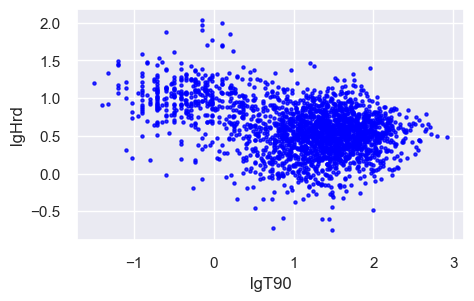

In [168]:
df_fermi_t90_hrd = dt.load_dataset(FERMI, FEATS, plot_data=True)
fermi_models = load_models(FERMI, FEATS)

Apply Hopkins statistic test. (if >0.75, then clusterable)

In [169]:
hopkins_fermi = st.hopkins_statistic(df_fermi_t90_hrd.values)
print("Data is clusterable." if hopkins_fermi>0.75 else "Data is not clusterable.")
clusterability_fermi = True if hopkins_fermi>0.75 else False

Data is clusterable.


Display all models.

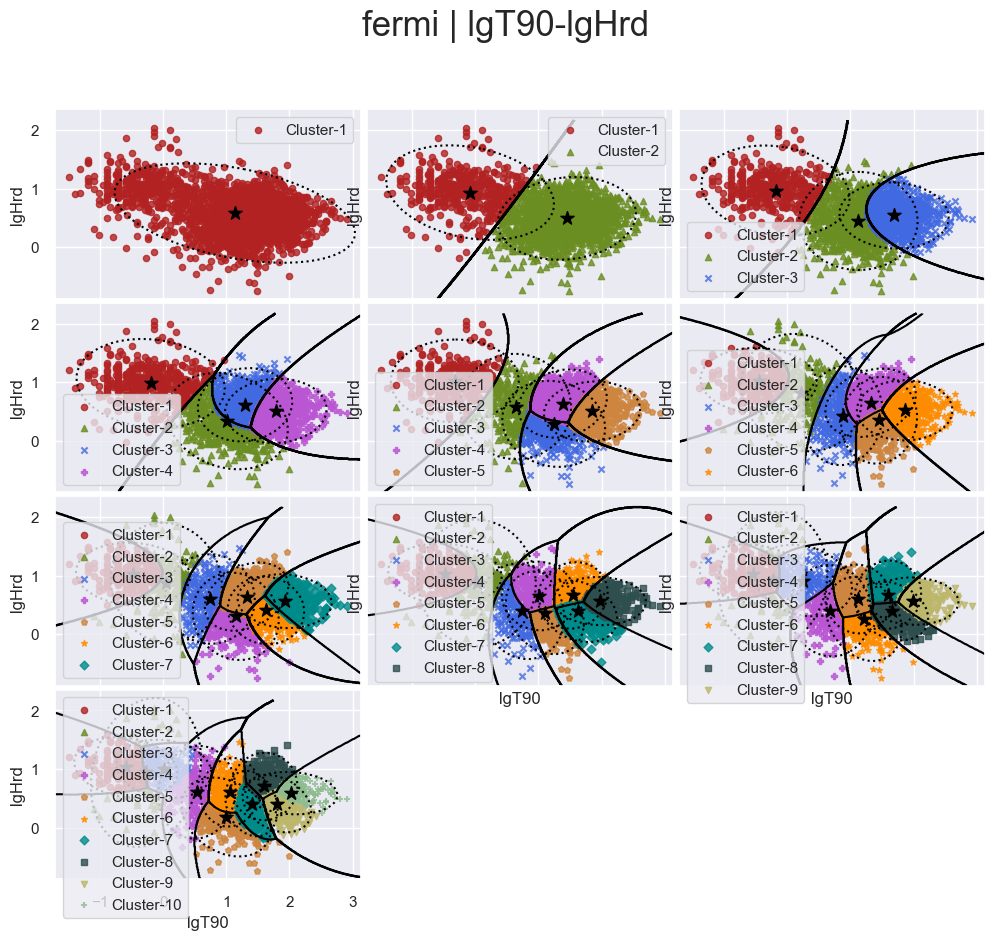

In [170]:
plot_models(fermi_models, df_fermi_t90_hrd)

Evaluate all models.

In [171]:
evaluate_models(fermi_models, df_fermi_t90_hrd, save=True)

[I]: [1/10] Evaluating model: fermi_lgT90-lgHrd_1G


[I]: [2/10] Evaluating model: fermi_lgT90-lgHrd_2G
[I]: [3/10] Evaluating model: fermi_lgT90-lgHrd_3G
[I]: [4/10] Evaluating model: fermi_lgT90-lgHrd_4G
[I]: [5/10] Evaluating model: fermi_lgT90-lgHrd_5G
[I]: [6/10] Evaluating model: fermi_lgT90-lgHrd_6G
[I]: [7/10] Evaluating model: fermi_lgT90-lgHrd_7G
[I]: [8/10] Evaluating model: fermi_lgT90-lgHrd_8G
[I]: [9/10] Evaluating model: fermi_lgT90-lgHrd_9G
[I]: [10/10] Evaluating model: fermi_lgT90-lgHrd_10G


Display model scores.

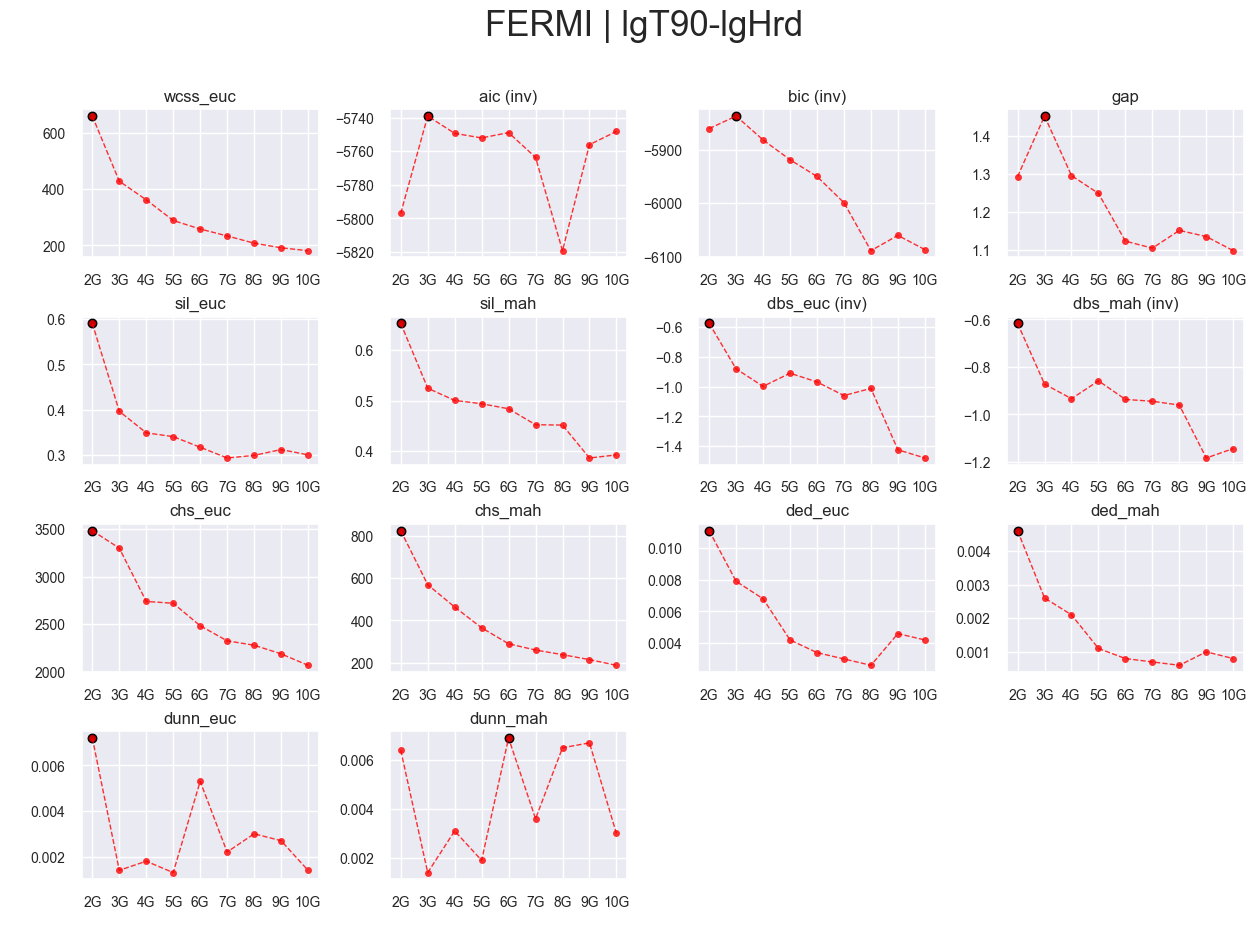

In [172]:
plot_scores(FERMI, FEATS, clusterable=clusterability_fermi)

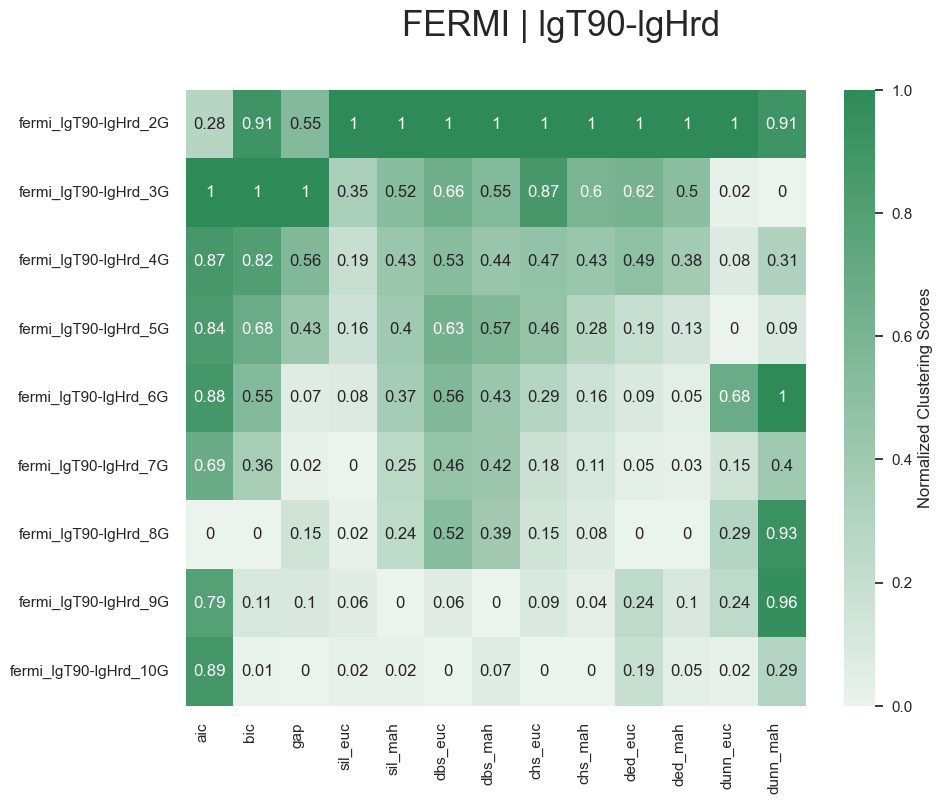

In [173]:
plot_heatmap(FERMI, FEATS, title=FERMI.upper() + " | " + "-".join(FEATS), clusterable=clusterability_fermi)

## 3. SWIFT/BAT

Load dataset and models.

[I]: >>> Dataset SWIFT loaded with features: ['lgT90', 'lgHrd']
[I]:   > Number of GRBs: 1470


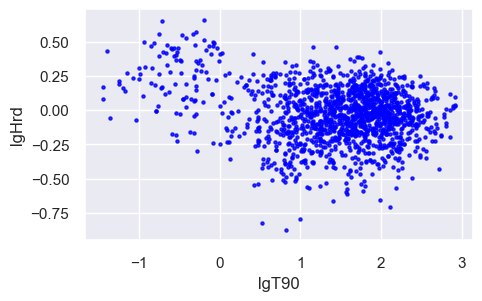

In [174]:
df_swift_t90_hrd = dt.load_dataset(SWIFT, FEATS, plot_data=True)
swift_models = load_models(SWIFT, FEATS)

Apply Hopkins statistic test. (if >0.75, then clusterable)

In [175]:
hopkins_swift = st.hopkins_statistic(df_swift_t90_hrd.values)
print("Data is clusterable." if hopkins_swift>0.75 else "Data is not clusterable.")
clusterability_swift = True if hopkins_swift>0.75 else False

Data is clusterable.


Display all models.

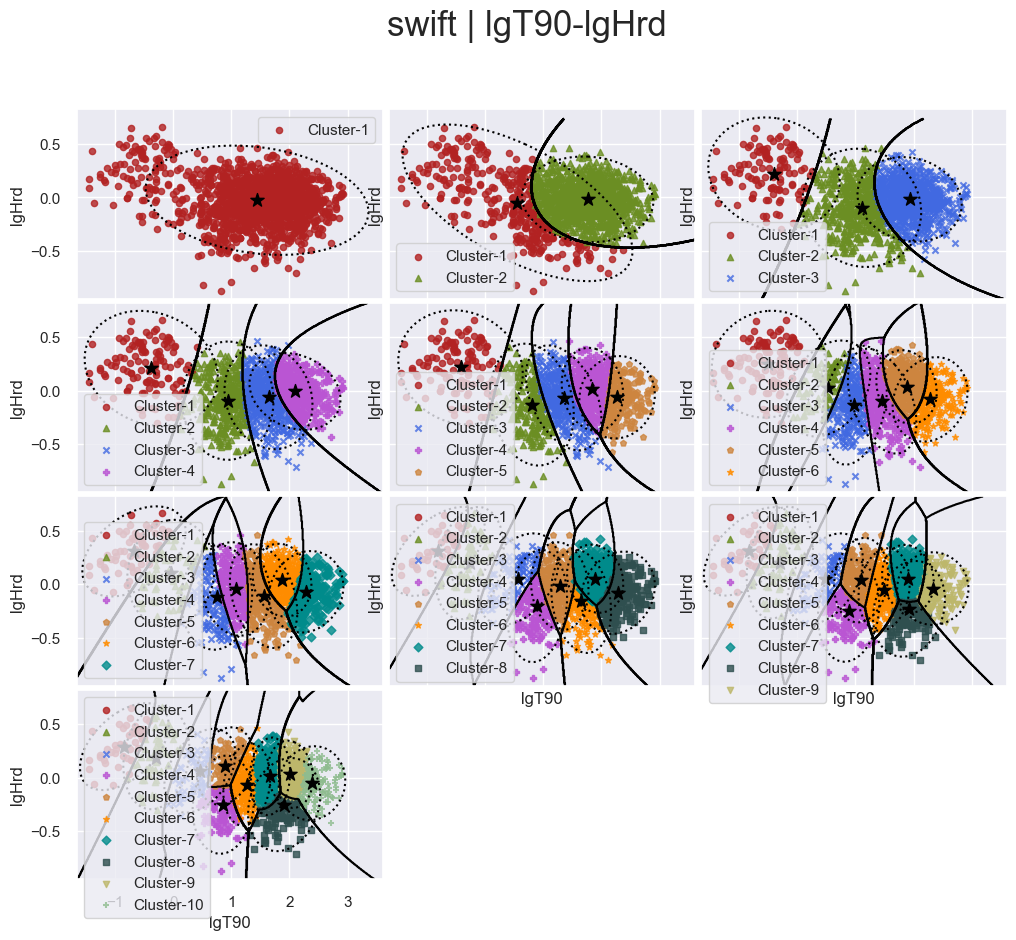

In [176]:
plot_models(swift_models, df_swift_t90_hrd)

Evaluate all models.

In [177]:
evaluate_models(swift_models, df_swift_t90_hrd, save=True)

[I]: [1/10] Evaluating model: swift_lgT90-lgHrd_1G
[I]: [2/10] Evaluating model: swift_lgT90-lgHrd_2G
[I]: [3/10] Evaluating model: swift_lgT90-lgHrd_3G
[I]: [4/10] Evaluating model: swift_lgT90-lgHrd_4G
[I]: [5/10] Evaluating model: swift_lgT90-lgHrd_5G
[I]: [6/10] Evaluating model: swift_lgT90-lgHrd_6G
[I]: [7/10] Evaluating model: swift_lgT90-lgHrd_7G
[I]: [8/10] Evaluating model: swift_lgT90-lgHrd_8G
[I]: [9/10] Evaluating model: swift_lgT90-lgHrd_9G
[I]: [10/10] Evaluating model: swift_lgT90-lgHrd_10G


Display model scores.

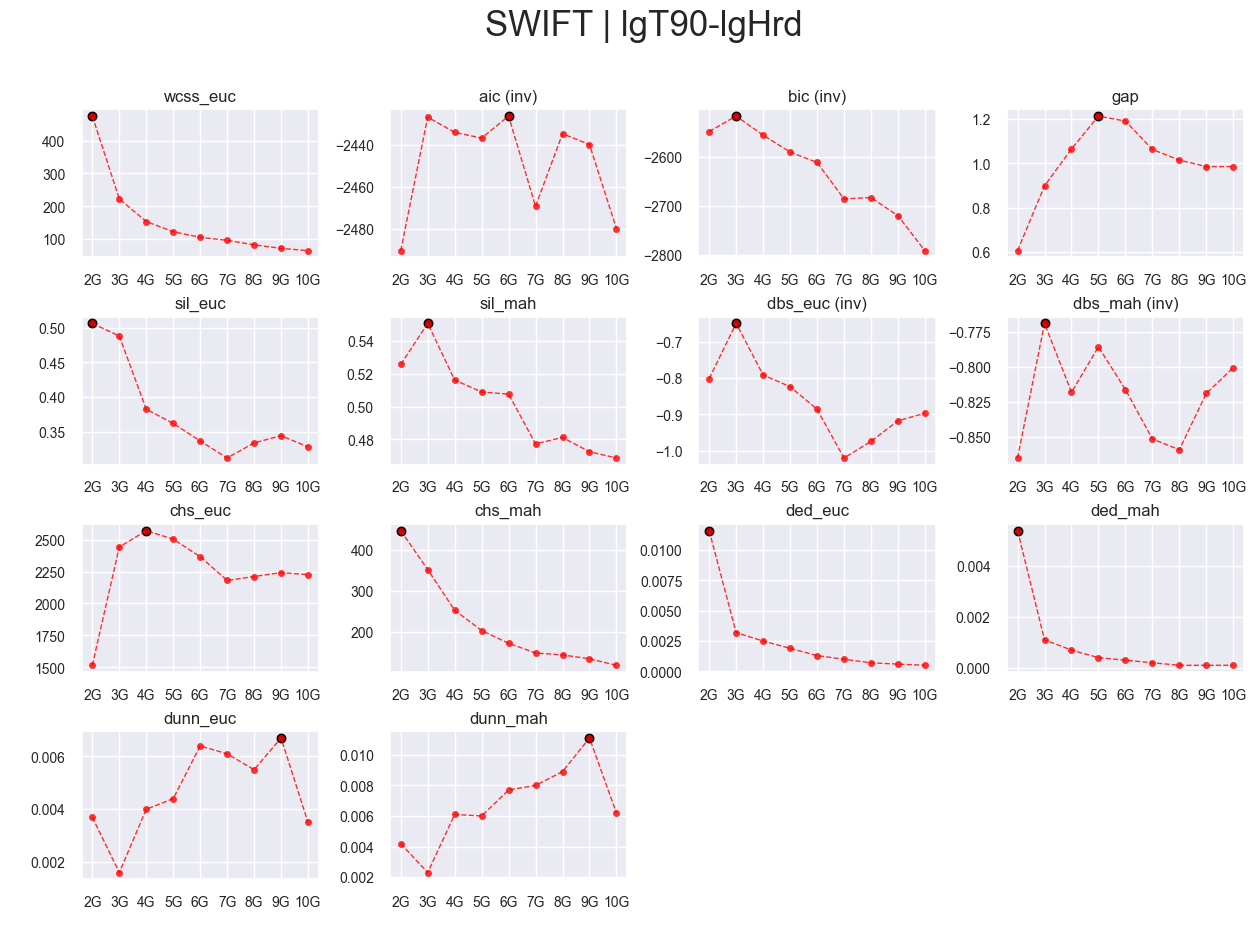

In [178]:
plot_scores(SWIFT, FEATS, clusterable=clusterability_swift)

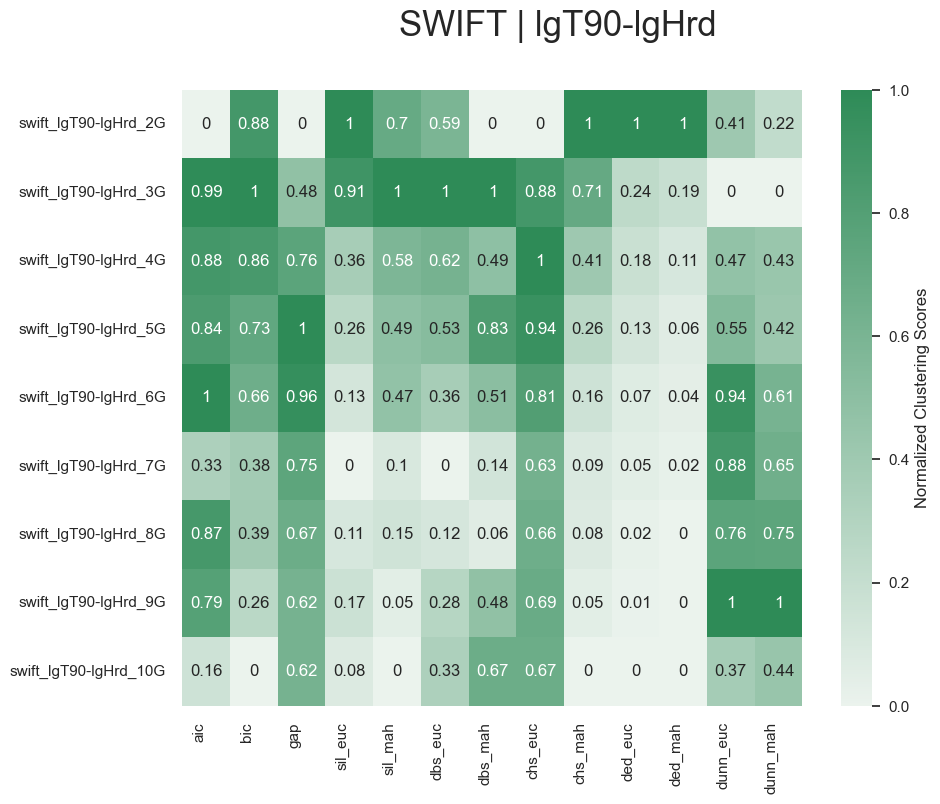

In [179]:
plot_heatmap(SWIFT, FEATS, title=SWIFT.upper() + " | " + "-".join(FEATS), clusterable=clusterability_swift)

-----

# CROSS-CATALOGUE ANALYSES